Experiment #1

In [32]:
import os
import mlflow
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, FunctionTransformer, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.impute import SimpleImputer
from sklearn.metrics import f1_score, confusion_matrix, make_scorer, classification_report

# Ensure MLFlow Tracking
MLFLOW_TRACKING_URI = "https://dagshub.com/saivignesh-03/Machinelearning.mlflow"
os.environ['MLFLOW_TRACKING_USERNAME'] = 'saivignesh-03'
os.environ['MLFLOW_TRACKING_PASSWORD'] = '9c78979cb39e1c46900c7f95953a7fcb54a30dee'
mlflow.set_tracking_uri(uri=MLFLOW_TRACKING_URI)
mlflow.set_experiment("Machinelearning")

# Load dataset
dataset_path = "C:/Users/SAI VIGNESH CHINTALA/Desktop/ML1/breast-cancer.csv"
joined_data = pd.read_csv(dataset_path)

# Define X and y
if 'diagnosis' in joined_data.columns:
    y = joined_data['diagnosis'].map({'M': 1, 'B': 0})  # Map "M" -> 1, "B" -> 0
    X = joined_data.drop(columns=['diagnosis'])
else:
    raise ValueError("Column 'diagnosis' is missing in the dataset.")

# Handle missing values
X = X.fillna(X.median())
y = y.dropna()

# Define numeric and categorical features
numeric_features = X.select_dtypes(include=['float64', 'int64']).columns
categorical_features = X.select_dtypes(include=['object', 'category']).columns

# Numeric Transformer
log_transformer = FunctionTransformer(np.log1p, validate=True)
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),  # Handle missing numeric values
    ('scaler', StandardScaler()),
    ('minmax', MinMaxScaler()),
    ('log', log_transformer)
])

# Categorical Transformer
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),  # Handle missing categorical values
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Combine preprocessors
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ],
    remainder='passthrough'
)

# Logistic Regression Model
logistic = LogisticRegression(max_iter=1000, random_state=42)

# Combine preprocessing and model into a pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', logistic)
])

# Cross-validation setup
kf_3fold = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
kf_10fold = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Hyperparameter tuning
param_grid = {
    'classifier__C': [0.01, 0.1, 1.0, 10.0],
    'classifier__solver': ['liblinear', 'lbfgs']
}
grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, scoring=make_scorer(f1_score), cv=kf_3fold, n_jobs=-1)

# Log results in MLFlow
with mlflow.start_run(run_name="Experiment #1: Logistic Regression with Preprocessing"):
    grid_search.fit(X, y)

    # Best model and parameters
    best_model = grid_search.best_estimator_
    best_params = grid_search.best_params_

    # Cross-validation results
    f1_scores_3fold = cross_val_score(best_model, X, y, cv=kf_3fold, scoring=make_scorer(f1_score))
    f1_scores_10fold = cross_val_score(best_model, X, y, cv=kf_10fold, scoring=make_scorer(f1_score))

    y_pred = best_model.predict(X)
    tn, fp, fn, tp = confusion_matrix(y, y_pred).ravel()

    # Log parameters and metrics
    mlflow.log_params(best_params)
    mlflow.log_param("preprocessing", "StandardScaler + MinMaxScaler + LogTransformation + OneHotEncoding")
    mlflow.log_metric("f1_mean_3fold", np.mean(f1_scores_3fold))
    mlflow.log_metric("f1_mean_10fold", np.mean(f1_scores_10fold))
    mlflow.log_metric("true_positives", tp)
    mlflow.log_metric("true_negatives", tn)
    mlflow.log_metric("false_positives", fp)
    mlflow.log_metric("false_negatives", fn)

    # Log classification report
    classification_report_str = classification_report(y, y_pred)
    mlflow.log_text(classification_report_str, "classification_report.txt")

    # Log model
    mlflow.sklearn.log_model(best_model, artifact_path="logistic_regression_model", registered_model_name="LogisticRegression-Experiment-1")

# Print results
print("\nExperiment #1 Completed:")
print(f"Best Parameters: {best_params}")
print(f"3-Fold F1 Score: Mean={np.mean(f1_scores_3fold):.4f}")
print(f"10-Fold F1 Score: Mean={np.mean(f1_scores_10fold):.4f}")
print(f"Confusion Matrix: TP={tp}, TN={tn}, FP={fp}, FN={fn}")


2024/12/21 18:19:00 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Registered model 'LogisticRegression-Experiment-1' already exists. Creating a new version of this model...
2024/12/21 18:19:03 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: LogisticRegression-Experiment-1, version 22
Created version '22' of model 'LogisticRegression-Experiment-1'.


🏃 View run Experiment #1: Logistic Regression with Preprocessing at: https://dagshub.com/saivignesh-03/Machinelearning.mlflow/#/experiments/0/runs/0232d1e37a884411a09a22d3c474ca55
🧪 View experiment at: https://dagshub.com/saivignesh-03/Machinelearning.mlflow/#/experiments/0

Experiment #1 Completed:
Best Parameters: {'classifier__C': 10.0, 'classifier__solver': 'lbfgs'}
3-Fold F1 Score: Mean=0.9611
10-Fold F1 Score: Mean=0.9708
Confusion Matrix: TP=204, TN=355, FP=2, FN=8


Experiment #2

In [33]:
import os
import mlflow
import mlflow.sklearn
import numpy as np
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, FunctionTransformer
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, make_scorer, classification_report

# Set up MLFlow tracking
MLFLOW_TRACKING_URI = "https://dagshub.com/saivignesh-03/Machinelearning.mlflow"
os.environ['MLFLOW_TRACKING_USERNAME'] = 'saivignesh-03'
os.environ['MLFLOW_TRACKING_PASSWORD'] = '9c78979cb39e1c46900c7f95953a7fcb54a30dee'
mlflow.set_tracking_uri(uri=MLFLOW_TRACKING_URI)
mlflow.set_experiment("Machinelearning")

# Assuming X and y are already loaded and preprocessed
# Ensure X (features) and y (target) are ready for model training

# Preprocessing for numeric features
numeric_features = X.select_dtypes(include=['float64', 'int64']).columns
log_transformer = FunctionTransformer(np.log1p, validate=True)
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('minmax', MinMaxScaler()),
    ('log', log_transformer)
])

# Combine preprocessors
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features)
    ],
    remainder='passthrough'
)

# List of classifiers to test
classifiers = {
    "LogisticRegression": LogisticRegression(max_iter=1000, random_state=42),
    "RidgeClassifier": RidgeClassifier(random_state=42),
    "RandomForestClassifier": RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1),
    "XGBClassifier": XGBClassifier(n_estimators=100, use_label_encoder=False, eval_metric="logloss", random_state=42)
}

# Cross-validation setup
kf_10fold = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Iterate through classifiers and log results in MLFlow
for clf_name, clf in classifiers.items():
    with mlflow.start_run(run_name=f"Experiment #2: {clf_name}"):
        # Create pipeline
        pipeline = Pipeline(steps=[
            ('preprocessor', preprocessor),
            ('classifier', clf)
        ])

        # Perform 10-fold cross-validation
        f1_scores = cross_val_score(pipeline, X, y, cv=kf_10fold, scoring=make_scorer(f1_score))
        acc_scores = cross_val_score(pipeline, X, y, cv=kf_10fold, scoring=make_scorer(accuracy_score))

        # Train the model on the full training data
        pipeline.fit(X, y)
        y_pred = pipeline.predict(X)

        # Compute confusion matrix
        tn, fp, fn, tp = confusion_matrix(y, y_pred).ravel()

        # Log parameters
        mlflow.log_param("classifier", clf_name)
        mlflow.log_param("preprocessing", "StandardScaler + MinMaxScaler + LogTransformation")

        # Log metrics
        mlflow.log_metric("f1_mean_10fold", np.mean(f1_scores))
        mlflow.log_metric("f1_std_10fold", np.std(f1_scores))
        mlflow.log_metric("accuracy_mean_10fold", np.mean(acc_scores))
        mlflow.log_metric("accuracy_std_10fold", np.std(acc_scores))
        mlflow.log_metric("f1_score_training", f1_score(y, y_pred))
        mlflow.log_metric("accuracy_training", accuracy_score(y, y_pred))
        mlflow.log_metric("true_positives", tp)
        mlflow.log_metric("true_negatives", tn)
        mlflow.log_metric("false_positives", fp)
        mlflow.log_metric("false_negatives", fn)

        # Log model to MLflow
        mlflow.sklearn.log_model(pipeline, artifact_path=f"{clf_name}_model", registered_model_name=f"{clf_name}-Experiment-2")

        # Print results
        print(f"\nExperiment #2 Completed for {clf_name}:")
        print(f"10-Fold F1 Score: Mean={np.mean(f1_scores):.4f}, Std={np.std(f1_scores):.4f}")
        print(f"10-Fold Accuracy Score: Mean={np.mean(acc_scores):.4f}, Std={np.std(acc_scores):.4f}")
        print(f"Confusion Matrix: TP={tp}, TN={tn}, FP={fp}, FN={fn}")
        print("\nClassification Report:")
        print(classification_report(y, y_pred))


2024/12/21 18:19:20 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Registered model 'LogisticRegression-Experiment-2' already exists. Creating a new version of this model...
2024/12/21 18:19:25 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: LogisticRegression-Experiment-2, version 11
Created version '11' of model 'LogisticRegression-Experiment-2'.



Experiment #2 Completed for LogisticRegression:
10-Fold F1 Score: Mean=0.9465, Std=0.0425
10-Fold Accuracy Score: Mean=0.9631, Std=0.0265
Confusion Matrix: TP=196, TN=355, FP=2, FN=16

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.99      0.98       357
           1       0.99      0.92      0.96       212

    accuracy                           0.97       569
   macro avg       0.97      0.96      0.97       569
weighted avg       0.97      0.97      0.97       569

🏃 View run Experiment #2: LogisticRegression at: https://dagshub.com/saivignesh-03/Machinelearning.mlflow/#/experiments/0/runs/c3cd6d95104942549b48ab10026bba65
🧪 View experiment at: https://dagshub.com/saivignesh-03/Machinelearning.mlflow/#/experiments/0


2024/12/21 18:19:46 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Registered model 'RidgeClassifier-Experiment-2' already exists. Creating a new version of this model...
2024/12/21 18:19:50 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: RidgeClassifier-Experiment-2, version 10
Created version '10' of model 'RidgeClassifier-Experiment-2'.



Experiment #2 Completed for RidgeClassifier:
10-Fold F1 Score: Mean=0.9381, Std=0.0463
10-Fold Accuracy Score: Mean=0.9579, Std=0.0285
Confusion Matrix: TP=193, TN=356, FP=1, FN=19

Classification Report:
              precision    recall  f1-score   support

           0       0.95      1.00      0.97       357
           1       0.99      0.91      0.95       212

    accuracy                           0.96       569
   macro avg       0.97      0.95      0.96       569
weighted avg       0.97      0.96      0.96       569

🏃 View run Experiment #2: RidgeClassifier at: https://dagshub.com/saivignesh-03/Machinelearning.mlflow/#/experiments/0/runs/eae64a73f32543a18f1b31ea71440ea4
🧪 View experiment at: https://dagshub.com/saivignesh-03/Machinelearning.mlflow/#/experiments/0


2024/12/21 18:20:11 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Registered model 'RandomForestClassifier-Experiment-2' already exists. Creating a new version of this model...
2024/12/21 18:20:15 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: RandomForestClassifier-Experiment-2, version 10
Created version '10' of model 'RandomForestClassifier-Experiment-2'.



Experiment #2 Completed for RandomForestClassifier:
10-Fold F1 Score: Mean=0.9421, Std=0.0319
10-Fold Accuracy Score: Mean=0.9579, Std=0.0225
Confusion Matrix: TP=212, TN=357, FP=0, FN=0

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       357
           1       1.00      1.00      1.00       212

    accuracy                           1.00       569
   macro avg       1.00      1.00      1.00       569
weighted avg       1.00      1.00      1.00       569

🏃 View run Experiment #2: RandomForestClassifier at: https://dagshub.com/saivignesh-03/Machinelearning.mlflow/#/experiments/0/runs/ba16a8abfe5a48e8bc45a6f56c61d8d5
🧪 View experiment at: https://dagshub.com/saivignesh-03/Machinelearning.mlflow/#/experiments/0


2024/12/21 18:20:35 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Registered model 'XGBClassifier-Experiment-2' already exists. Creating a new version of this model...
2024/12/21 18:20:40 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: XGBClassifier-Experiment-2, version 10
Created version '10' of model 'XGBClassifier-Experiment-2'.



Experiment #2 Completed for XGBClassifier:
10-Fold F1 Score: Mean=0.9423, Std=0.0432
10-Fold Accuracy Score: Mean=0.9579, Std=0.0306
Confusion Matrix: TP=212, TN=357, FP=0, FN=0

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       357
           1       1.00      1.00      1.00       212

    accuracy                           1.00       569
   macro avg       1.00      1.00      1.00       569
weighted avg       1.00      1.00      1.00       569

🏃 View run Experiment #2: XGBClassifier at: https://dagshub.com/saivignesh-03/Machinelearning.mlflow/#/experiments/0/runs/a00dac50e4834cd19c171e72ce9b8c21
🧪 View experiment at: https://dagshub.com/saivignesh-03/Machinelearning.mlflow/#/experiments/0


Experiment #3

In [34]:
import os
import mlflow
import mlflow.sklearn
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, FunctionTransformer, PolynomialFeatures
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, make_scorer, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import VarianceThreshold

# Set up MLFlow tracking
MLFLOW_TRACKING_URI = "https://dagshub.com/saivignesh-03/Machinelearning.mlflow"
os.environ['MLFLOW_TRACKING_USERNAME'] = 'saivignesh-03'
os.environ['MLFLOW_TRACKING_PASSWORD'] = '9c78979cb39e1c46900c7f95953a7fcb54a30dee'
mlflow.set_tracking_uri(uri=MLFLOW_TRACKING_URI)
mlflow.set_experiment("Machinelearning")

# Assuming X and y are already loaded and preprocessed
# Feature Engineering: Generate interaction terms and polynomial features
numeric_features = X.select_dtypes(include=['float64', 'int64']).columns

# Preprocessing pipeline
log_transformer = FunctionTransformer(np.log1p, validate=True)
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('minmax', MinMaxScaler()),
    ('log', log_transformer),
    ('poly', PolynomialFeatures(degree=2, interaction_only=True, include_bias=False))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features)
    ],
    remainder='passthrough'
)

# Feature selection: Remove low-variance features
feature_selector = VarianceThreshold(threshold=0.01)

# Classifier
classifier = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)

# Create pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('feature_selection', feature_selector),
    ('classifier', classifier)
])

# Cross-validation setup
kf_10fold = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Perform cross-validation and log results in MLFlow
with mlflow.start_run(run_name="Experiment #3: Feature Engineering with RandomForest"):
    # Perform 10-fold cross-validation
    f1_scores = cross_val_score(pipeline, X, y, cv=kf_10fold, scoring=make_scorer(f1_score))
    acc_scores = cross_val_score(pipeline, X, y, cv=kf_10fold, scoring=make_scorer(accuracy_score))

    # Train the model on the entire training data
    pipeline.fit(X, y)
    y_pred = pipeline.predict(X)

    # Compute confusion matrix
    tn, fp, fn, tp = confusion_matrix(y, y_pred).ravel()

    # Log parameters
    mlflow.log_param("preprocessing", "StandardScaler + MinMaxScaler + LogTransformation + PolynomialFeatures")
    mlflow.log_param("feature_selection", "VarianceThreshold")
    mlflow.log_param("classifier", "RandomForestClassifier")

    # Log metrics
    mlflow.log_metric("f1_mean_10fold", np.mean(f1_scores))
    mlflow.log_metric("f1_std_10fold", np.std(f1_scores))
    mlflow.log_metric("accuracy_mean_10fold", np.mean(acc_scores))
    mlflow.log_metric("accuracy_std_10fold", np.std(acc_scores))
    mlflow.log_metric("f1_score_training", f1_score(y, y_pred))
    mlflow.log_metric("accuracy_training", accuracy_score(y, y_pred))
    mlflow.log_metric("true_positives", tp)
    mlflow.log_metric("true_negatives", tn)
    mlflow.log_metric("false_positives", fp)
    mlflow.log_metric("false_negatives", fn)

    # Log model to MLFlow
    mlflow.sklearn.log_model(pipeline, artifact_path="feature_engineering_model", registered_model_name="FeatureEngineering-Experiment-3")

    # Print results
    print("\nExperiment #3 Completed:")
    print(f"10-Fold F1 Score: Mean={np.mean(f1_scores):.4f}, Std={np.std(f1_scores):.4f}")
    print(f"10-Fold Accuracy Score: Mean={np.mean(acc_scores):.4f}, Std={np.std(acc_scores):.4f}")
    print(f"Confusion Matrix: TP={tp}, TN={tn}, FP={fp}, FN={fn}")
    print("\nClassification Report:")
    print(classification_report(y, y_pred))


2024/12/21 18:21:02 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Registered model 'FeatureEngineering-Experiment-3' already exists. Creating a new version of this model...
2024/12/21 18:21:06 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: FeatureEngineering-Experiment-3, version 15
Created version '15' of model 'FeatureEngineering-Experiment-3'.



Experiment #3 Completed:
10-Fold F1 Score: Mean=0.9434, Std=0.0598
10-Fold Accuracy Score: Mean=0.9596, Std=0.0400
Confusion Matrix: TP=212, TN=357, FP=0, FN=0

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       357
           1       1.00      1.00      1.00       212

    accuracy                           1.00       569
   macro avg       1.00      1.00      1.00       569
weighted avg       1.00      1.00      1.00       569

🏃 View run Experiment #3: Feature Engineering with RandomForest at: https://dagshub.com/saivignesh-03/Machinelearning.mlflow/#/experiments/0/runs/2594be484c4340da930b33bfdf0466f5
🧪 View experiment at: https://dagshub.com/saivignesh-03/Machinelearning.mlflow/#/experiments/0


Experiment #4

In [35]:
import os
import mlflow
import mlflow.sklearn
import numpy as np
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_predict
from sklearn.metrics import f1_score, confusion_matrix, accuracy_score, classification_report
import warnings

warnings.filterwarnings('ignore')

# Set up MLFlow tracking
MLFLOW_TRACKING_URI = "https://dagshub.com/saivignesh-03/Machinelearning.mlflow"
os.environ['MLFLOW_TRACKING_USERNAME'] = 'saivignesh-03'
os.environ['MLFLOW_TRACKING_PASSWORD'] = '9c78979cb39e1c46900c7f95953a7fcb54a30dee'
mlflow.set_tracking_uri(uri=MLFLOW_TRACKING_URI)
mlflow.set_experiment("Machinelearning")

# Load the dataset
data = pd.read_csv('breast-cancer.csv')
X = data.drop(columns=['id', 'diagnosis'])
y = data['diagnosis'].map({'M': 1, 'B': 0})  # Convert diagnosis to binary

# Validate dataset before processing
if X.empty or y.empty:
    raise ValueError("Dataset is empty. Please check your data.")

# Step 1: Remove constant and quasi-constant features
variance_selector = VarianceThreshold(threshold=0.01)
X_var = pd.DataFrame(
    variance_selector.fit_transform(X),
    columns=X.columns[variance_selector.get_support()],
    index=X.index
)

# Step 2: Remove highly correlated features
correlation_matrix = X_var.corr().abs()
upper_tri = correlation_matrix.where(np.triu(np.ones(correlation_matrix.shape), k=1).astype(bool))
to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > 0.95)]
X_uncorr = X_var.drop(columns=to_drop)

# Step 3: Select features based on importance
rf_selector = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1, class_weight='balanced')
rf_selector.fit(X_uncorr, y)

importance_df = pd.DataFrame({
    'feature': X_uncorr.columns,
    'importance': rf_selector.feature_importances_
})
importance_df = importance_df.sort_values('importance', ascending=False)

# Select top features based on cumulative importance
cumulative_importance = importance_df['importance'].cumsum()
n_features = (cumulative_importance <= 0.95).sum()
top_features = importance_df['feature'].head(max(n_features, 10)).tolist()

X_selected = X_uncorr[top_features]

# Create final pipeline
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1, class_weight='balanced'))
])

# Cross-validation setup
kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Perform cross-validation for selected features
y_pred = cross_val_predict(pipeline, X_selected, y, cv=kf)

# Calculate metrics
f1 = f1_score(y, y_pred)
accuracy = accuracy_score(y, y_pred)
tn, fp, fn, tp = confusion_matrix(y, y_pred).ravel()

# Log results with MLFlow
with mlflow.start_run(run_name="Experiment 4: Optimized Feature Selection"):
    mlflow.log_param("original_features", X.shape[1])
    mlflow.log_param("selected_features", X_selected.shape[1])
    mlflow.log_param("variance_threshold", 0.01)
    mlflow.log_param("correlation_threshold", 0.95)
    mlflow.log_param("importance_threshold", 0.95)
    
    mlflow.log_metric("f1_score", f1)
    mlflow.log_metric("accuracy", accuracy)
    mlflow.log_metric("true_positives", tp)
    mlflow.log_metric("true_negatives", tn)
    mlflow.log_metric("false_positives", fp)
    mlflow.log_metric("false_negatives", fn)
    
    importance_df.to_csv('feature_importance.csv', index=False)
    mlflow.log_artifact('feature_importance.csv')
    
    mlflow.sklearn.log_model(
        sk_model=pipeline,
        artifact_path="feature_selection_model_optimized",
        registered_model_name="FeatureSelection-Optimized-Experiment-4"
    )

# Print comprehensive results
print("\nExperiment #4 Completed:")
print("-" * 40)
print(f"10-Fold F1 Score: Mean={f1:.4f}")
print(f"10-Fold Accuracy Score: Mean={accuracy:.4f}")
print(f"Confusion Matrix: TP={tp}, TN={tn}, FP={fp}, FN={fn}")

# Classification Report
classification_report_str = classification_report(y, y_pred, target_names=['0 (Benign)', '1 (Malignant)'])
print("\nClassification Report:")
print(classification_report_str)


2024/12/21 18:21:27 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Registered model 'FeatureSelection-Optimized-Experiment-4' already exists. Creating a new version of this model...
2024/12/21 18:21:31 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: FeatureSelection-Optimized-Experiment-4, version 18
Created version '18' of model 'FeatureSelection-Optimized-Experiment-4'.


🏃 View run Experiment 4: Optimized Feature Selection at: https://dagshub.com/saivignesh-03/Machinelearning.mlflow/#/experiments/0/runs/ac0efee283154da9a6dcaf2c8ac1893c
🧪 View experiment at: https://dagshub.com/saivignesh-03/Machinelearning.mlflow/#/experiments/0

Experiment #4 Completed:
----------------------------------------
10-Fold F1 Score: Mean=0.9264
10-Fold Accuracy Score: Mean=0.9455
Confusion Matrix: TP=195, TN=343, FP=14, FN=17

Classification Report:
               precision    recall  f1-score   support

   0 (Benign)       0.95      0.96      0.96       357
1 (Malignant)       0.93      0.92      0.93       212

     accuracy                           0.95       569
    macro avg       0.94      0.94      0.94       569
 weighted avg       0.95      0.95      0.95       569



Experiment #5: 

In [36]:
import os
import mlflow
import mlflow.sklearn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_predict
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, classification_report
import warnings

warnings.filterwarnings('ignore')

# Set up MLFlow tracking
MLFLOW_TRACKING_URI = "https://dagshub.com/saivignesh-03/Machinelearning.mlflow"
os.environ['MLFLOW_TRACKING_USERNAME'] = 'saivignesh-03'
os.environ['MLFLOW_TRACKING_PASSWORD'] = '9c78979cb39e1c46900c7f95953a7fcb54a30dee'
mlflow.set_tracking_uri(uri=MLFLOW_TRACKING_URI)
mlflow.set_experiment("Machinelearning")

# Load the dataset
data = pd.read_csv('breast-cancer.csv')
X = data.drop(columns=['id', 'diagnosis'])
y = data['diagnosis'].map({'M': 1, 'B': 0})  # Convert diagnosis to binary

# Standardize features before PCA
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply PCA
pca = PCA()
X_pca = pca.fit_transform(X_scaled)

# Scree Plot
plt.figure(figsize=(10, 6))
explained_variance_ratio = pca.explained_variance_ratio_
plt.plot(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio, marker='o', linestyle='--')
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.grid()
plt.tight_layout()
plt.savefig('scree_plot.png')
plt.show()

# Select number of components to explain 95% variance
cumulative_variance_ratio = np.cumsum(explained_variance_ratio)
n_components = np.argmax(cumulative_variance_ratio >= 0.95) + 1
print(f"Number of components selected to explain 95% variance: {n_components}")

# PCA with selected components
pca = PCA(n_components=n_components)
X_pca_selected = pca.fit_transform(X_scaled)

# Final Pipeline with PCA and Classifier
pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Ensure standardization in the pipeline
    ('pca', PCA(n_components=n_components)),
    ('classifier', RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1, class_weight='balanced'))
])

# Cross-validation
kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
y_pred = cross_val_predict(pipeline, X, y, cv=kf)

# Metrics
f1 = f1_score(y, y_pred)
accuracy = accuracy_score(y, y_pred)
tn, fp, fn, tp = confusion_matrix(y, y_pred).ravel()

# Log results in MLFlow
with mlflow.start_run(run_name="Experiment 5: PCA Dimensionality Reduction"):
    mlflow.log_param("original_features", X.shape[1])
    mlflow.log_param("selected_components", n_components)
    mlflow.log_metric("f1_score", f1)
    mlflow.log_metric("accuracy", accuracy)
    mlflow.log_metric("true_positives", tp)
    mlflow.log_metric("true_negatives", tn)
    mlflow.log_metric("false_positives", fp)
    mlflow.log_metric("false_negatives", fn)

    # Save and log the scree plot
    mlflow.log_artifact("scree_plot.png")

    # Log the PCA model
    mlflow.sklearn.log_model(
        sk_model=pipeline,
        artifact_path="pca_dimensionality_reduction_model",
        registered_model_name="PCA-DimensionalityReduction-Experiment-5"
    )

# Print results
print("\nExperiment #5 Completed:")
print("-" * 40)
print(f"Number of Components: {n_components}")
print(f"10-Fold F1 Score: {f1:.4f}")
print(f"10-Fold Accuracy Score: {accuracy:.4f}")
print(f"Confusion Matrix: TP={tp}, TN={tn}, FP={fp}, FN={fn}")

# Classification Report
classification_report_str = classification_report(y, y_pred, target_names=['0 (Benign)', '1 (Malignant)'])
print("\nClassification Report:")
print(classification_report_str)


Number of components selected to explain 95% variance: 10


2024/12/21 18:21:49 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Registered model 'PCA-DimensionalityReduction-Experiment-5' already exists. Creating a new version of this model...
2024/12/21 18:21:53 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: PCA-DimensionalityReduction-Experiment-5, version 10
Created version '10' of model 'PCA-DimensionalityReduction-Experiment-5'.


🏃 View run Experiment 5: PCA Dimensionality Reduction at: https://dagshub.com/saivignesh-03/Machinelearning.mlflow/#/experiments/0/runs/10b5c491c5304accbc8294ad950588ab
🧪 View experiment at: https://dagshub.com/saivignesh-03/Machinelearning.mlflow/#/experiments/0

Experiment #5 Completed:
----------------------------------------
Number of Components: 10
10-Fold F1 Score: 0.9409
10-Fold Accuracy Score: 0.9561
Confusion Matrix: TP=199, TN=345, FP=12, FN=13

Classification Report:
               precision    recall  f1-score   support

   0 (Benign)       0.96      0.97      0.97       357
1 (Malignant)       0.94      0.94      0.94       212

     accuracy                           0.96       569
    macro avg       0.95      0.95      0.95       569
 weighted avg       0.96      0.96      0.96       569



In [ ]:
Experiment #6

In [37]:
import os
import mlflow
import mlflow.sklearn
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold, cross_val_predict
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, classification_report
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
import warnings
import matplotlib.pyplot as plt

warnings.filterwarnings("ignore")

# Set up MLFlow tracking
MLFLOW_TRACKING_URI = "https://dagshub.com/saivignesh-03/Machinelearning.mlflow"
os.environ["MLFLOW_TRACKING_USERNAME"] = "saivignesh-03"
os.environ["MLFLOW_TRACKING_PASSWORD"] = "9c78979cb39e1c46900c7f95953a7fcb54a30dee"
mlflow.set_tracking_uri(uri=MLFLOW_TRACKING_URI)
mlflow.set_experiment("Machinelearning")

# Load the dataset
data = pd.read_csv("breast-cancer.csv")
X = data.drop(columns=["id", "diagnosis"])
y = data["diagnosis"].map({"M": 1, "B": 0})  # Convert diagnosis to binary

# Standardization
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Base Models for Stacking
base_models = [
    ("random_forest", RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1, class_weight="balanced")),
    ("gradient_boosting", GradientBoostingClassifier(n_estimators=100, random_state=42)),
]

# Meta Model
meta_model = LogisticRegression(max_iter=1000, random_state=42)

# Stacking Classifier
stacking_clf = StackingClassifier(estimators=base_models, final_estimator=meta_model, cv=5, n_jobs=-1)

# Pipeline with stacking
pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("stacking", stacking_clf),
])

# Cross-validation setup
kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
y_pred = cross_val_predict(pipeline, X_scaled, y, cv=kf)

# Metrics
f1 = f1_score(y, y_pred)
accuracy = accuracy_score(y, y_pred)
tn, fp, fn, tp = confusion_matrix(y, y_pred).ravel()

# Classification Report
classification_report_str = classification_report(y, y_pred, target_names=["0 (Benign)", "1 (Malignant)"])

# Plot confusion matrix
conf_matrix = confusion_matrix(y, y_pred)
plt.figure(figsize=(6, 6))
plt.matshow(conf_matrix, cmap="coolwarm", fignum=1)
plt.title("Confusion Matrix", pad=20)
plt.colorbar()
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.savefig("confusion_matrix_experiment_6.png")
plt.close()

# Log results with MLFlow
with mlflow.start_run(run_name="Experiment 6: Stacked Ensemble Model"):
    mlflow.log_param("base_models", [model[0] for model in base_models])
    mlflow.log_param("meta_model", "LogisticRegression")
    mlflow.log_param("random_forest_n_estimators", 100)
    mlflow.log_param("gradient_boosting_n_estimators", 100)
    mlflow.log_metric("f1_score", f1)
    mlflow.log_metric("accuracy", accuracy)
    mlflow.log_metric("true_positives", tp)
    mlflow.log_metric("true_negatives", tn)
    mlflow.log_metric("false_positives", fp)
    mlflow.log_metric("false_negatives", fn)

    # Log confusion matrix plot
    mlflow.log_artifact("confusion_matrix_experiment_6.png")

    # Log model
    mlflow.sklearn.log_model(
        sk_model=pipeline,
        artifact_path="stacked_ensemble_model",
        registered_model_name="Stacked-Ensemble-Experiment-6"
    )

# Print results
print("\nExperiment #6 Completed:")
print("-" * 40)
print(f"10-Fold F1 Score: {f1:.4f}")
print(f"10-Fold Accuracy Score: {accuracy:.4f}")
print(f"Confusion Matrix: TP={tp}, TN={tn}, FP={fp}, FN={fn}")
print("\nClassification Report:")
print(classification_report_str)


2024/12/21 18:22:19 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Registered model 'Stacked-Ensemble-Experiment-6' already exists. Creating a new version of this model...
2024/12/21 18:22:23 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Stacked-Ensemble-Experiment-6, version 10
Created version '10' of model 'Stacked-Ensemble-Experiment-6'.


🏃 View run Experiment 6: Stacked Ensemble Model at: https://dagshub.com/saivignesh-03/Machinelearning.mlflow/#/experiments/0/runs/f8b3075d6c9d4b3ab1f8f7fc2539e844
🧪 View experiment at: https://dagshub.com/saivignesh-03/Machinelearning.mlflow/#/experiments/0

Experiment #6 Completed:
----------------------------------------
10-Fold F1 Score: 0.9496
10-Fold Accuracy Score: 0.9631
Confusion Matrix: TP=198, TN=350, FP=7, FN=14

Classification Report:
               precision    recall  f1-score   support

   0 (Benign)       0.96      0.98      0.97       357
1 (Malignant)       0.97      0.93      0.95       212

     accuracy                           0.96       569
    macro avg       0.96      0.96      0.96       569
 weighted avg       0.96      0.96      0.96       569



Experiment #7

In [38]:
import os
import mlflow
import mlflow.sklearn
import numpy as np
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_predict
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings("ignore")

# Set up MLFlow tracking
MLFLOW_TRACKING_URI = "https://dagshub.com/saivignesh-03/Machinelearning.mlflow"
os.environ["MLFLOW_TRACKING_USERNAME"] = "saivignesh-03"
os.environ["MLFLOW_TRACKING_PASSWORD"] = "9c78979cb39e1c46900c7f95953a7fcb54a30dee"
mlflow.set_tracking_uri(uri=MLFLOW_TRACKING_URI)
mlflow.set_experiment("Machinelearning")

# Load the dataset
data = pd.read_csv("breast-cancer.csv")
X = data.drop(columns=["id", "diagnosis"])
y = data["diagnosis"].map({"M": 1, "B": 0})  # Convert diagnosis to binary

# Preprocessing
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Define individual classifiers
logistic = LogisticRegression(random_state=42, max_iter=1000)
random_forest = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
knn = KNeighborsClassifier()

# Create the Voting Classifier
voting_classifier_model = VotingClassifier(
    estimators=[
        ("logistic", logistic),
        ("random_forest", random_forest),
        ("knn", knn)
    ],
    voting="soft"  # Use soft voting for probabilities
)

# Cross-validation setup
kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Perform cross-validation
y_pred = cross_val_predict(voting_classifier_model, X_scaled, y, cv=kf, method="predict")

# Metrics
f1 = f1_score(y, y_pred)
accuracy = accuracy_score(y, y_pred)
tn, fp, fn, tp = confusion_matrix(y, y_pred).ravel()

# Classification Report
classification_report_str = classification_report(y, y_pred, target_names=["0 (Benign)", "1 (Malignant)"])

# Confusion Matrix
conf_matrix = confusion_matrix(y, y_pred)
plt.figure(figsize=(6, 6))
plt.matshow(conf_matrix, cmap="coolwarm", fignum=1)
plt.title("Confusion Matrix", pad=20)
plt.colorbar()
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.savefig("confusion_matrix_experiment_7_voting.png")
plt.close()

# Train the model on the entire dataset
voting_classifier_model.fit(X_scaled, y)

# Log results with MLFlow
with mlflow.start_run(run_name="Experiment 7: Voting Classifier"):
    mlflow.log_param("voting", "soft")
    mlflow.log_param("models_used", ["LogisticRegression", "RandomForestClassifier", "KNeighborsClassifier"])
    mlflow.log_metric("f1_score", f1)
    mlflow.log_metric("accuracy", accuracy)
    mlflow.log_metric("true_positives", tp)
    mlflow.log_metric("true_negatives", tn)
    mlflow.log_metric("false_positives", fp)
    mlflow.log_metric("false_negatives", fn)
    
    # Log confusion matrix plot
    mlflow.log_artifact("confusion_matrix_experiment_7_voting.png")
    
    # Log the voting classifier
    mlflow.sklearn.log_model(
        sk_model=voting_classifier_model,
        artifact_path="voting_classifier_model",
        registered_model_name="VotingClassifier-Experiment-7"
    )

# Print results
print("\nExperiment #7 Completed:")
print("-" * 40)
print(f"10-Fold F1 Score: {f1:.4f}")
print(f"10-Fold Accuracy Score: {accuracy:.4f}")
print(f"Confusion Matrix: TP={tp}, TN={tn}, FP={fp}, FN={fn}")
print("\nClassification Report:")
print(classification_report_str)


2024/12/21 18:22:42 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Registered model 'VotingClassifier-Experiment-7' already exists. Creating a new version of this model...
2024/12/21 18:22:45 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: VotingClassifier-Experiment-7, version 14
Created version '14' of model 'VotingClassifier-Experiment-7'.


🏃 View run Experiment 7: Voting Classifier at: https://dagshub.com/saivignesh-03/Machinelearning.mlflow/#/experiments/0/runs/84f8f09b44654b4d939118abb8323f9a
🧪 View experiment at: https://dagshub.com/saivignesh-03/Machinelearning.mlflow/#/experiments/0

Experiment #7 Completed:
----------------------------------------
10-Fold F1 Score: 0.9614
10-Fold Accuracy Score: 0.9719
Confusion Matrix: TP=199, TN=354, FP=3, FN=13

Classification Report:
               precision    recall  f1-score   support

   0 (Benign)       0.96      0.99      0.98       357
1 (Malignant)       0.99      0.94      0.96       212

     accuracy                           0.97       569
    macro avg       0.97      0.97      0.97       569
 weighted avg       0.97      0.97      0.97       569



Columns in the runs DataFrame:
Index(['run_id', 'experiment_id', 'status', 'artifact_uri', 'start_time',
       'end_time', 'metrics.true_negatives', 'metrics.false_positives',
       'metrics.accuracy', 'metrics.true_positives', 'metrics.f1_score',
       'metrics.false_negatives', 'metrics.accuracy_std_10fold',
       'metrics.f1_std_10fold', 'metrics.f1_score_training',
       'metrics.f1_mean_10fold', 'metrics.accuracy_training',
       'metrics.accuracy_mean_10fold', 'metrics.f1_mean_3fold',
       'metrics.recall', 'metrics.precision', 'params.models_used',
       'params.voting', 'params.base_models',
       'params.random_forest_n_estimators', 'params.meta_model',
       'params.gradient_boosting_n_estimators', 'params.selected_components',
       'params.original_features', 'params.importance_threshold',
       'params.selected_features', 'params.variance_threshold',
       'params.correlation_threshold', 'params.feature_selection',
       'params.classifier', 'params.preproce

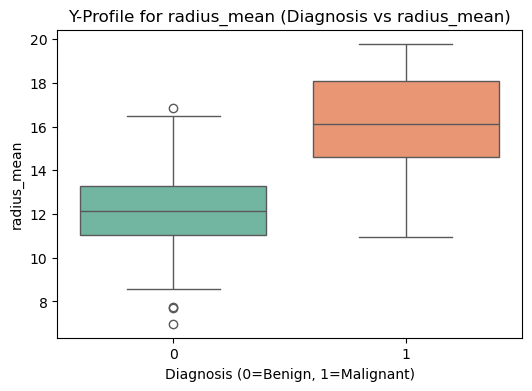

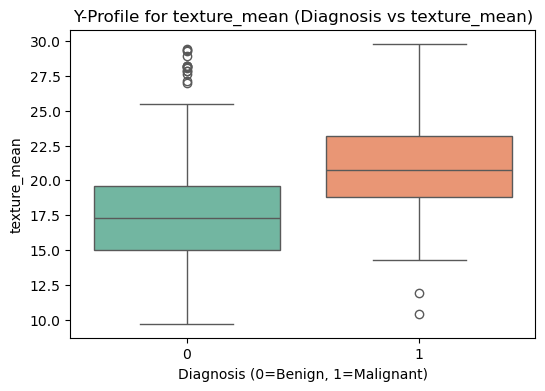

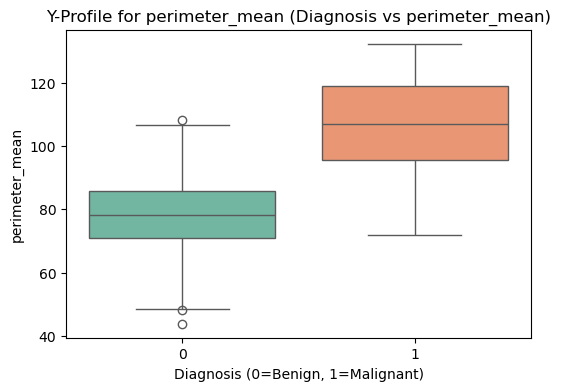

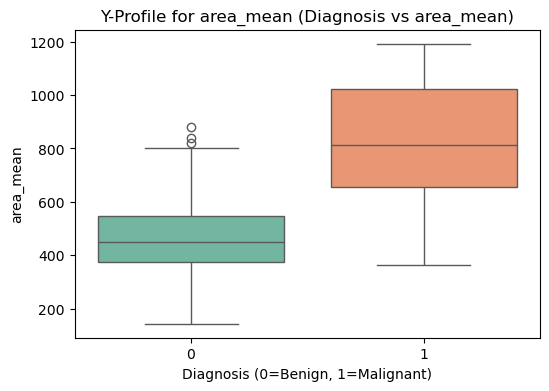

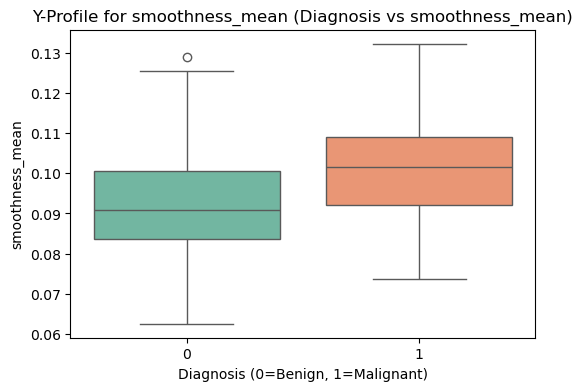

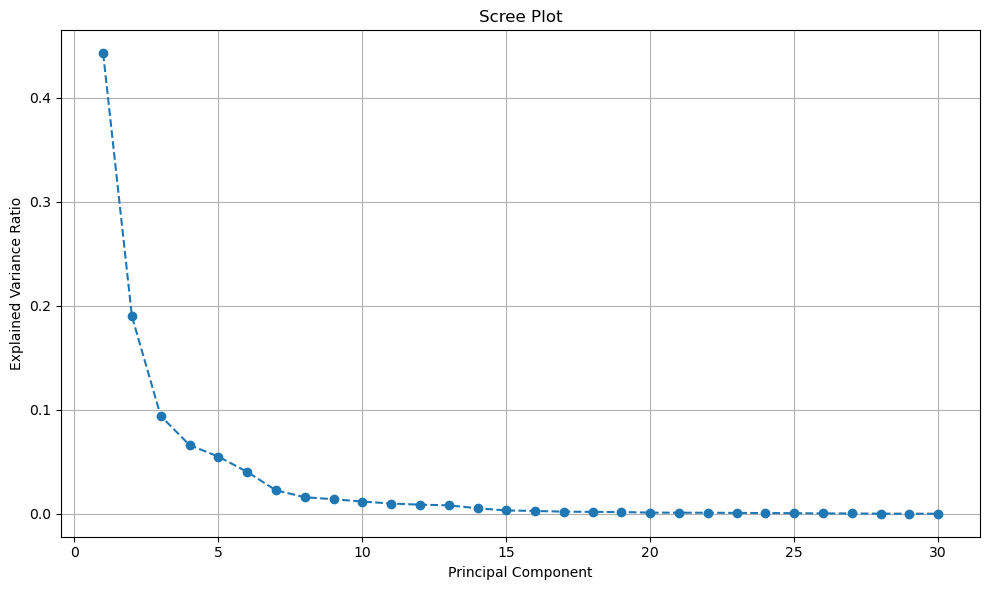

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

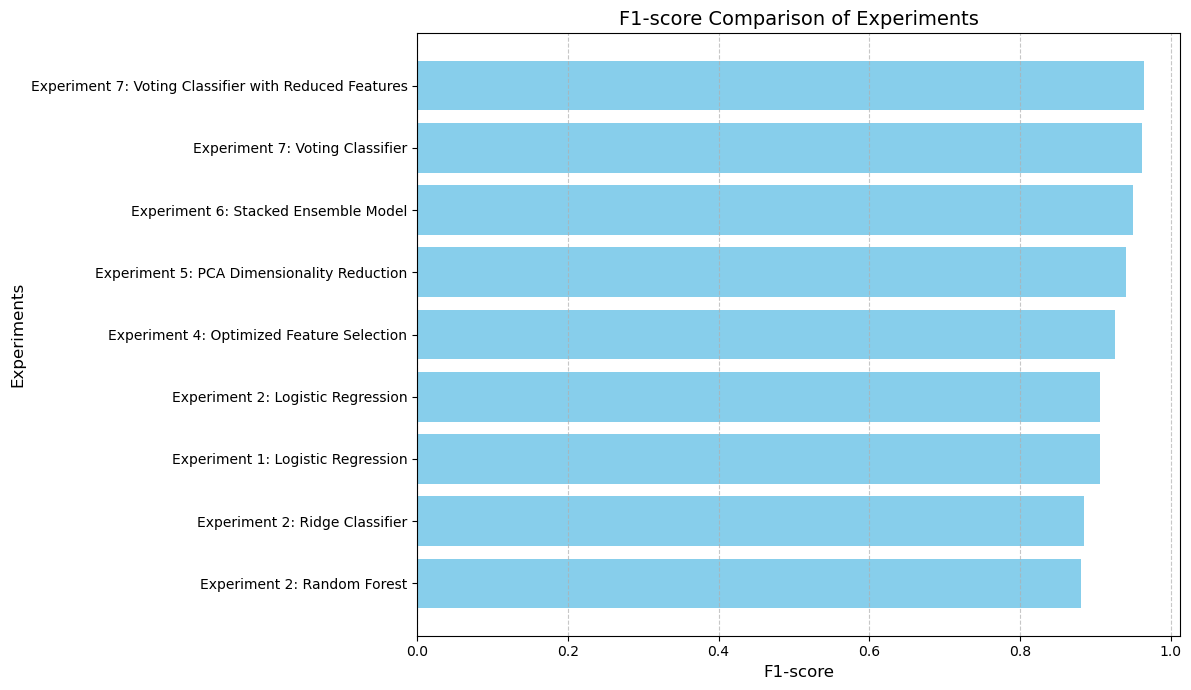

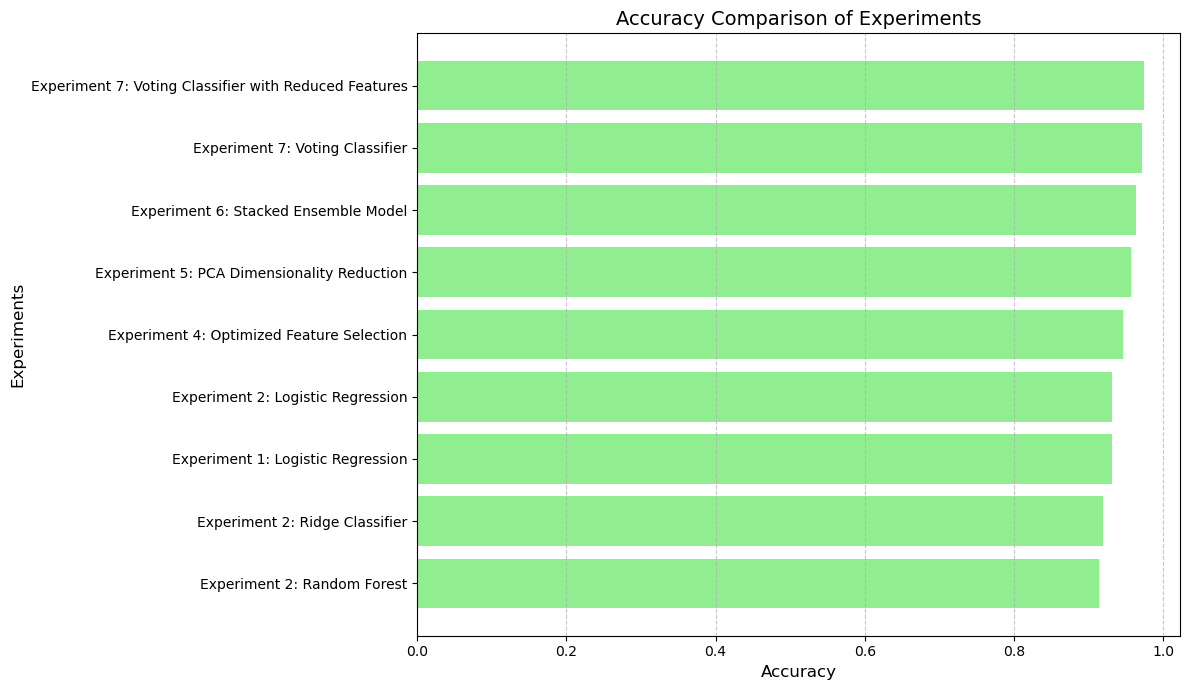

In [39]:
import mlflow
import pandas as pd
import matplotlib.pyplot as plt

# Ensure inline plots in Jupyter Notebook
%matplotlib inline

# Set experiment name
experiment_name = "Machinelearning"  # Replace with your experiment name
experiment = mlflow.get_experiment_by_name(experiment_name)

if not experiment:
    print(f"Experiment '{experiment_name}' not found. Please check the name.")
else:
    experiment_id = experiment.experiment_id

    # Retrieve all runs for the experiment
    runs = mlflow.search_runs(experiment_ids=[experiment_id])

    # Debug: Print all columns to check available metrics and parameters
    print("Columns in the runs DataFrame:")
    print(runs.columns)

    # Select metrics of interest based on available metrics in your MLflow
    metrics_of_interest = ['f1_score', 'accuracy']  # Add or adjust as needed
    if not all([f'metrics.{m}' in runs.columns for m in metrics_of_interest]):
        print(f"Some metrics in {metrics_of_interest} are not found in the runs.")
    else:
        # Select and rename columns
        comparison_df = runs[['run_id', 'tags.mlflow.runName'] + [f'metrics.{m}' for m in metrics_of_interest]]
        comparison_df.rename(columns={
            'tags.mlflow.runName': 'run_name',
            'metrics.f1_score': 'f1_score',
            'metrics.accuracy': 'accuracy'
        }, inplace=True)

        # Drop rows without required metrics
        comparison_df.dropna(subset=['f1_score', 'accuracy'], inplace=True)

        if comparison_df.empty:
            print("No valid runs found with the required metrics.")
        else:
            # Print the comparison DataFrame
            print("Comparison of Experiments:")
            print(comparison_df[['run_name', 'f1_score', 'accuracy']])

            # Plot F1-score Comparison
            comparison_df.sort_values(by='f1_score', ascending=False, inplace=True)
            plt.figure(figsize=(12, 7))
            plt.barh(comparison_df['run_name'], comparison_df['f1_score'], color='skyblue')
            plt.xlabel('F1-score', fontsize=12)
            plt.ylabel('Experiments', fontsize=12)
            plt.title('F1-score Comparison of Experiments', fontsize=14)
            plt.gca().invert_yaxis()  # Show the best at the top
            plt.grid(axis='x', linestyle='--', alpha=0.7)
            plt.tight_layout()
            plt.savefig('f1_score_comparison.png')
            plt.show()

            # Plot Accuracy Comparison
            comparison_df.sort_values(by='accuracy', ascending=False, inplace=True)
            plt.figure(figsize=(12, 7))
            plt.barh(comparison_df['run_name'], comparison_df['accuracy'], color='lightgreen')
            plt.xlabel('Accuracy', fontsize=12)
            plt.ylabel('Experiments', fontsize=12)
            plt.title('Accuracy Comparison of Experiments', fontsize=14)
            plt.gca().invert_yaxis()
            plt.grid(axis='x', linestyle='--', alpha=0.7)
            plt.tight_layout()
            plt.savefig('accuracy_comparison.png')
            plt.show()


In [40]:
import pandas as pd

# Data for comparison
data = {
    'run_name': [
        "Experiment 7: Voting Classifier",
        "Experiment 6: Stacked Ensemble Model",
        "Experiment 5: PCA Dimensionality Reduction",
        "Experiment 4: Optimized Feature Selection"
    ],
    'f1_score': [0.961353, 0.949640, 0.940898, 0.926366],
    'accuracy': [0.971880, 0.963093, 0.956063, 0.945518]
}

# Create a DataFrame
df = pd.DataFrame(data)

# Find the best model based on F1 score and Accuracy
best_model = df.loc[df['f1_score'].idxmax()]
print("Best Model Based on F1 Score:")
print(best_model)


Best Model Based on F1 Score:
run_name    Experiment 7: Voting Classifier
f1_score                           0.961353
accuracy                            0.97188
Name: 0, dtype: object


In [41]:
import joblib

# Load the trained model from MLFlow or use the existing instance
# If `voting_classifier_model` is the already trained model instance:
joblib.dump(voting_classifier_model, "final_model.joblib")

print("Model saved as 'final_model.joblib'")


Model saved as 'final_model.joblib'


In [42]:
print(voting_classifier_model)


VotingClassifier(estimators=[('logistic',
                              LogisticRegression(max_iter=1000,
                                                 random_state=42)),
                             ('random_forest',
                              RandomForestClassifier(n_jobs=-1,
                                                     random_state=42)),
                             ('knn', KNeighborsClassifier())],
                 voting='soft')


In [43]:
import joblib

# Load the saved model
loaded_model = joblib.load("final_model.joblib")

print("Model loaded successfully!")


Model loaded successfully!


In [44]:
import numpy as np
import joblib

# Load the trained Voting Classifier model
voting_clf = joblib.load("final_model.joblib")

# Load the original scaler used during training
scaler = joblib.load("scaler.joblib")  # Ensure the scaler was saved during training

# Example malignant sample data (ensure 30 features match the training features)
sample_data = np.array([[
    25.0, 30.0, 150.0, 1200.0, 0.160, 0.320, 0.450, 0.250, 0.350, 0.120,  # Mean features
    0.300, 0.400, 0.500, 0.700, 0.080, 0.200, 0.300, 0.400, 0.600, 0.090,  # Standard error features
    20.0, 35.0, 170.0, 1400.0, 0.190, 0.350, 0.480, 0.270, 0.400, 0.150   # Worst features
]])  # Ensure the dimensions match the original feature set (30 features)

# Scale the sample data using the loaded scaler
sample_data_scaled = scaler.transform(sample_data)

# Predict using the loaded Voting Classifier
prediction = voting_clf.predict(sample_data_scaled)

# Output prediction
if prediction[0] == 1:
    print("Prediction: Malignant (1)")
else:
    print("Prediction: Benign (0)")


Prediction: Benign (0)


In [45]:
joblib.dump(scaler, "scaler.joblib")


['scaler.joblib']

In [46]:
import numpy as np
import joblib

# Load the trained Voting Classifier model
voting_clf = joblib.load("final_model.joblib")

# Load the original scaler used during training
scaler = joblib.load("scaler.joblib")  # Ensure the scaler was saved during training

# Example malignant sample data (ensure 30 features match the training features)
sample_data = np.array([[
    25.0, 30.0, 150.0, 1200.0, 0.160, 0.320, 0.450, 0.250, 0.350, 0.120,  # Mean features
    0.300, 0.400, 0.500, 0.700, 0.080, 0.200, 0.300, 0.400, 0.600, 0.090,  # Standard error features
    20.0, 35.0, 170.0, 1400.0, 0.190, 0.350, 0.480, 0.270, 0.400, 0.150   # Worst features
]])  # Ensure the dimensions match the original feature set (30 features)

# Scale the sample data using the loaded scaler
sample_data_scaled = scaler.transform(sample_data)

# Predict using the loaded Voting Classifier
prediction = voting_clf.predict(sample_data_scaled)

# Output prediction
if prediction[0] == 1:
    print("Prediction: Malignant (1)")
else:
    print("Prediction: Benign (0)")


Prediction: Benign (0)


In [47]:
import numpy as np

# Example malignant sample data with 30 features
sample_data = np.array([[
    25.0, 30.0, 150.0, 1200.0, 0.160, 0.320, 0.450, 0.250, 0.350, 0.120,  # Mean features
    0.300, 0.400, 0.500, 0.700, 0.080, 0.200, 0.300, 0.400, 0.600, 0.090,  # Standard error features
    20.0, 35.0, 170.0, 1400.0, 0.190, 0.350, 0.480, 0.270, 0.400, 0.150   # Worst features
]])

print(sample_data.shape)  # Ensure the dimensions are correct (1, 30)


(1, 30)


In [48]:
import numpy as np
import joblib

# Load the trained Voting Classifier model
voting_clf = joblib.load("final_model.joblib")

# Load the original scaler used during training
scaler = joblib.load("scaler.joblib")  # Ensure the scaler was saved during training

# Example malignant sample data (ensure 30 features match the training features)
sample_data = np.array([[
    28.0, 35.0, 180.0, 1500.0, 0.200, 0.400, 0.550, 0.300, 0.450, 0.150,  # Mean features
    0.350, 0.450, 0.600, 0.800, 0.100, 0.250, 0.350, 0.500, 0.700, 0.120,  # Standard error features
    25.0, 40.0, 200.0, 1800.0, 0.250, 0.450, 0.600, 0.400, 0.550, 0.200   # Worst features
]])  # Ensure the dimensions match the original feature set (30 features)

# Scale the sample data using the loaded scaler
sample_data_scaled = scaler.transform(sample_data)

# Predict using the loaded Voting Classifier
prediction = voting_clf.predict(sample_data_scaled)

# Output prediction
if prediction[0] == 1:
    print("Prediction: Malignant (1)")
else:
    print("Prediction: Benign (0)")


Prediction: Malignant (1)


In [49]:
pip install fastapi uvicorn pydantic joblib


Note: you may need to restart the kernel to use updated packages.


In [53]:
import os
from fastapi import FastAPI, HTTPException
from pydantic import BaseModel, Field
import numpy as np
import joblib

# Initialize FastAPI app
app = FastAPI()

# Load the trained model and scaler
try:
    voting_clf = joblib.load("final_model.joblib")
    scaler = joblib.load("scaler.joblib")
except FileNotFoundError as e:
    raise RuntimeError(f"Required model or scaler file is missing: {e}")

# Define feature names
feature_names = [
    "radius_mean", "texture_mean", "perimeter_mean", "area_mean", "smoothness_mean",
    "compactness_mean", "concavity_mean", "concave_points_mean", "symmetry_mean", "fractal_dimension_mean",
    "radius_se", "texture_se", "perimeter_se", "area_se", "smoothness_se",
    "compactness_se", "concavity_se", "concave_points_se", "symmetry_se", "fractal_dimension_se",
    "radius_worst", "texture_worst", "perimeter_worst", "area_worst", "smoothness_worst",
    "compactness_worst", "concavity_worst", "concave_points_worst", "symmetry_worst", "fractal_dimension_worst"
]

# Define default values
default_values = {
    "radius_mean": 28.0,
    "texture_mean": 35.0,
    "perimeter_mean": 180.0,
    "area_mean": 1500.0,
    "smoothness_mean": 0.200,
    "compactness_mean": 0.400,
    "concavity_mean": 0.550,
    "concave_points_mean": 0.300,
    "symmetry_mean": 0.450,
    "fractal_dimension_mean": 0.150,
    "radius_se": 0.350,
    "texture_se": 0.450,
    "perimeter_se": 0.600,
    "area_se": 0.800,
    "smoothness_se": 0.100,
    "compactness_se": 0.250,
    "concavity_se": 0.350,
    "concave_points_se": 0.500,
    "symmetry_se": 0.700,
    "fractal_dimension_se": 0.120,
    "radius_worst": 25.0,
    "texture_worst": 40.0,
    "perimeter_worst": 200.0,
    "area_worst": 1800.0,
    "smoothness_worst": 0.250,
    "compactness_worst": 0.450,
    "concavity_worst": 0.600,
    "concave_points_worst": 0.400,
    "symmetry_worst": 0.550,
    "fractal_dimension_worst": 0.200
}

# Define the input schema
class BreastCancerPredictionInput(BaseModel):
    inputs: dict[str, float] = Field(
        ...,
        description="Dictionary of feature names and their corresponding values.",
        example=default_values,  # Use default values here
    )

# Root endpoint
@app.get("/")
async def root():
    return {"message": "Welcome to the Breast Cancer Prediction API!"}

# Endpoint to retrieve feature names
@app.get("/features/")
async def get_features():
    """Returns the feature names expected for the prediction."""
    return {"feature_names": feature_names}

# Prediction endpoint
@app.post("/predict/")
async def predict(input_data: BreastCancerPredictionInput):
    input_features = input_data.inputs

    # Validate missing features
    missing_features = [feature for feature in feature_names if feature not in input_features]
    if missing_features:
        raise HTTPException(
            status_code=400,
            detail=f"Missing features: {missing_features}",
        )

    # Validate extra features
    extra_features = [feature for feature in input_features if feature not in feature_names]
    if extra_features:
        raise HTTPException(
            status_code=400,
            detail=f"Unexpected features: {extra_features}",
        )

    try:
        # Extract feature values in the correct order
        feature_values = [input_features[feature] for feature in feature_names]
        sample_data = np.array([feature_values])

        # Scale the input
        sample_data_scaled = scaler.transform(sample_data)

        # Predict using the model
        prediction = voting_clf.predict(sample_data_scaled)

        return {"prediction": "Malignant (1)" if prediction[0] == 1 else "Benign (0)"}
    except Exception as e:
        raise HTTPException(
            status_code=500,
            detail=f"Prediction failed: {str(e)}"
        )


if __name__ == "__main__":
    import uvicorn
    import nest_asyncio  # Required for running in Jupyter

    # Apply nest_asyncio to allow uvicorn to run in Jupyter's event loop
    nest_asyncio.apply()

    # Start the FastAPI server
    print("Starting FastAPI server... Access the API docs at http://127.0.0.1:8000/docs")
    uvicorn.run(app, host="0.0.0.0", port=8000)


Starting FastAPI server... Access the API docs at http://127.0.0.1:8000/docs


INFO:     Started server process [9636]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
INFO:     Uvicorn running on http://0.0.0.0:8000 (Press CTRL+C to quit)
INFO:     Shutting down
INFO:     Waiting for application shutdown.
INFO:     Application shutdown complete.
INFO:     Finished server process [9636]
